<span>
<b>Author:</b> <a href="http://about.giuliorossetti.net">Giulio Rossetti</a><br/>
<b>Python version:</b>  >=3.7<br/>
<b>Networkx version:</b>  >=2.3<br/>
<b>Last update:</b> 24/02/2021
</span>

<a id='top'></a>
# *Chapter 7: Ties Strength & Resilience*

In this notebook are introduced some of the main analysis discussed in lecture 7.

**Note:** this notebook is purposely not 100% comprehensive, it only discusses the basic things you need to get started. 

In [1]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

## Tie Strength

In [2]:
def read_net_w(filename):
    g = nx.Graph()
    with open(filename) as f:
        f.readline()
        for l in f:
            l = l.split(",")
            g.add_edge(l[0], l[1], weight=int(l[2]))
    return g

# Game of Thrones data
season = 6
g = read_net_w(f'data/asioaf/got-s{season}-edges.csv')

In [3]:
def node_overlap(g):
    for u, v in g.edges():
        n_u = set(g.neighbors(u))
        n_v = set(g.neighbors(v))
        overlap = len(n_u & n_v) / len(n_u | n_v)
        g[u][v]['overlap'] = overlap
    return g

In [4]:
g = node_overlap(g)

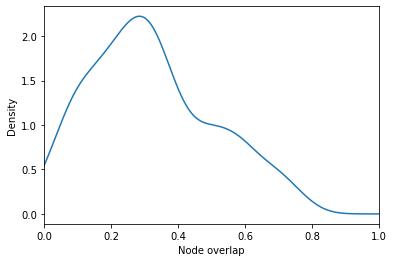

In [5]:
weights = [e[-1]['overlap'] for e in g.edges(data=True)]
pd.DataFrame(weights)[0].plot.kde()
plt.xlabel("Node overlap")
plt.xlim(0,1)
plt.show()

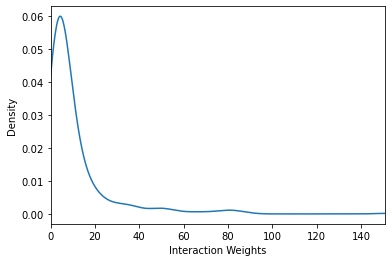

In [6]:
weights_got = [d['weight'] for u,v,d in g.edges(data=True)]
pd.DataFrame(weights_got)[0].plot.kde()
plt.xlabel("Interaction Weights")
plt.xlim(0,max(weights_got))
plt.show()

## Network Resilience

In [7]:
er = nx.erdos_renyi_graph(1000, 0.001)
ba = nx.barabasi_albert_graph(1000, 2)

In [8]:
er_degs = list(dict(er.degree()).values())
ba_degs = list(dict(ba.degree()).values())

Molloy-Reed threshold

In [9]:
def molloy_reed(degrees):
    return (np.mean(degrees)*(np.mean(degrees)+1))/np.mean(degrees)

def breakdown_threshold(degrees):
    K = molloy_reed(degrees)
    return 1 - (1/(K-1))

Random graph

In [10]:
molloy_reed(er_degs)

2.02

In [11]:
breakdown_threshold(er_degs)

0.019607843137254943

Scale-free graph

In [12]:
molloy_reed(ba_degs)

4.992

In [13]:
breakdown_threshold(ba_degs)

0.7494989979959921

### Random Failures

In [14]:
def random_node(g):
    return [np.random.choice(g.nodes())]

def dismantle(g, function, **args):
    total_nodes = g.number_of_nodes()
    removed_nodes = []
    components = []
    while len(g.nodes()) != 0:
        n = function(g, **args)[0]
        g.remove_node(n)
        removed_nodes.append((len(removed_nodes)+1)/total_nodes)
        comps = list(nx.connected_components(g))
        g_size = 0
        if len(comps)>0:
            g_size  = max([len(c)for c in comps])/total_nodes
        components.append(g_size)
    return removed_nodes, components

def get_sorted_nodes(g, score, reverse=True):
    nodes = score(g)
    if isinstance(nodes, dict):
        nodes = [(k, v) for k, v in nodes.items()]
    srt = sorted(nodes, key = lambda k: k[1], reverse = reverse)
    return [x[0] for x in srt]

def plot_dismantle(x, y):
    plt.plot(x, y)
    plt.xlabel("Removed Nodes")
    plt.ylabel("Giant Component size")
    plt.show()

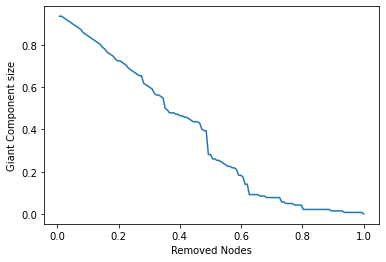

In [15]:
h = g.copy()
rn, comps = dismantle(h, random_node)
plot_dismantle(rn, comps)

### Targeted Attacks

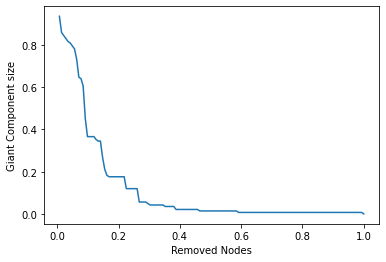

In [16]:
h = g.copy()
rn, comps = dismantle(h, get_sorted_nodes, score=nx.degree)
plot_dismantle(rn, comps)

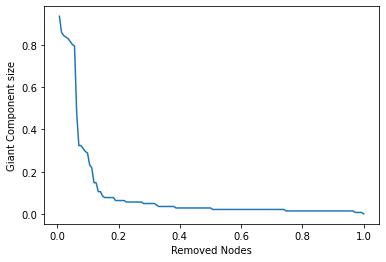

In [17]:
h = g.copy()
rn, comps = dismantle(h, get_sorted_nodes, score=nx.betweenness_centrality)
plot_dismantle(rn, comps)

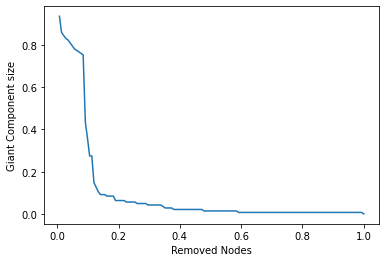

In [18]:
h = g.copy()
rn, comps = dismantle(h, get_sorted_nodes, score=nx.harmonic_centrality)
plot_dismantle(rn, comps)